# Processamento de Linguagem Natural (PLN)
_Natural Language Processing (NLP) em Inglês_

## Análise de Sentimentos - Twitter

Identificar se o tweet é **racista/sexista** ou **não**

In [1]:
import pandas as pd # pip install pandas
import seaborn as sns # pip install seaborn
import matplotlib.pyplot as plt # pip install matplotlib
%matplotlib inline

import nltk # pip install nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

import re

# pip install scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix

In [2]:
# nltk.download() # descomente para instalar pacotes do nlkt

### Ler dados

In [3]:
train = pd.read_csv('twitter/train.csv')
test = pd.read_csv('twitter/test.csv')

In [4]:
train.shape, test.shape

((31962, 3), (17197, 2))

In [5]:
train.head() # caso o label seja 1, é racista ou sexista, se for 0 não é

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [6]:
test.head() # o objetivo do test é descobrir os labels

,id,tweet
0,31963,#studiolife #aislife #requires #passion #dedic...
1,31964,@user #white #supremacists want everyone to s...
2,31965,safe ways to heal your #acne!! #altwaystohe...
3,31966,is the hp and the cursed child book up for res...
4,31967,"3rd #bihday to my amazing, hilarious #nephew..."


## Pré-processamento de Dados

### Tirar pontuações e caracteres especiais

In [7]:
# Expressão Regular
# r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"

In [8]:
train['tweet'] = train['tweet'].str.lower() # deixar tudo em minúsculas

In [9]:
train['tweet'] = train['tweet'].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '', x))

In [10]:
train.head()

,id,label,tweet
0,1,0,when a father is dysfunctional and is so sel...
1,2,0,thanks for lyft credit i cant use cause they...
2,3,0,bihday your majesty
3,4,0,model i love u take with u all the time in u...
4,5,0,factsguide society now motivation


In [11]:
def normalizaTexto(data, col):
    '''
        Tira pontuações e caracteres especiais, recebendo um DataFrame e uma coluna
    '''
    data[col] = data[col].str.lower() # deixar tudo em minúsculas
    data[col] = data[col].apply(lambda x: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", '', x))

In [12]:
normalizaTexto(test, 'tweet')

In [13]:
test.head()

,id,tweet
0,31963,studiolife aislife requires passion dedication...
1,31964,white supremacists want everyone to see the ...
2,31965,safe ways to heal your acne altwaystoheal h...
3,31966,is the hp and the cursed child book up for res...
4,31967,3rd bihday to my amazing hilarious nephew el...


### Remover palavras comuns

In [14]:
def remove_palavras_comuns(data, col):
    palavras_comuns = stopwords.words('english')
    lista_de_lista_de_palavras = data['tweet'].str.split()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [palavra for palavra in lista_de_lista_de_palavras[idx] \
                             if palavra not in palavras_comuns]

In [15]:
remove_palavras_comuns(train, 'tweet')

In [16]:
remove_palavras_comuns(test, 'tweet')

### Remover variações da mesma palavra

In [17]:
def tira_variacoes_de_palavras(data, col):
    tira_variacao = WordNetLemmatizer()
    for idx, _ in data.iterrows():
        data[col].at[idx] = [tira_variacao.lemmatize(palavra,'v') \
                             for palavra in data[col][idx]]

In [18]:
tira_variacoes_de_palavras(train, 'tweet')

In [19]:
tira_variacoes_de_palavras(test, 'tweet')

## Engenharia de Recursos (Feature Engineering ) 
### Quantidade de palavras por tweet

In [20]:
train['palavras'] = train['tweet'].apply(len)

In [21]:
test['palavras'] = test['tweet'].apply(len)

In [22]:
test.head()

,id,tweet,palavras
0,31963,"[studiolife, aislife, require, passion, dedica...",8
1,31964,"[white, supremacists, want, everyone, see, new...",9
2,31965,"[safe, ways, heal, acne, altwaystoheal, health...",7
3,31966,"[hp, curse, child, book, reservations, already...",10
4,31967,"[3rd, bihday, amaze, hilarious, nephew, eli, a...",11


## Análise Exploratória de Dados (AED)

### Distribuição das quantidades de palavras por "label"

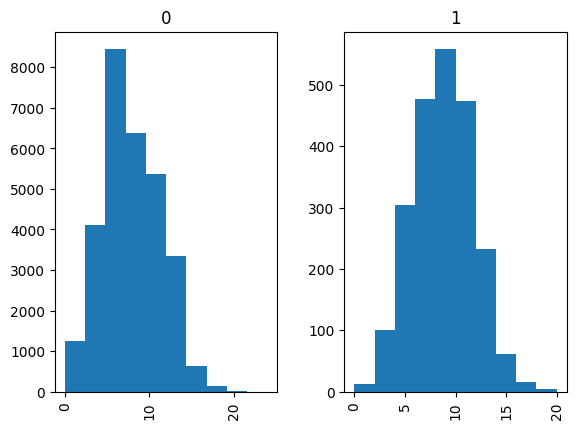

In [23]:
train.hist(column=['palavras'], by='label')
plt.show()

A distribuição é bem parecida, portanto dificilmente isso será útil

### Quantidade de cada "label"

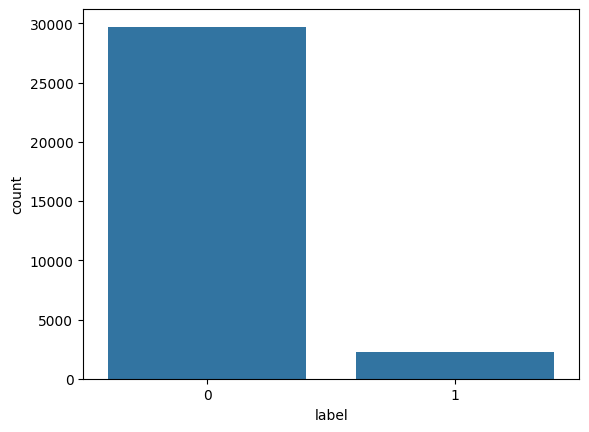

In [24]:
sns.countplot(x='label', data=train)
plt.show()

### Palavras frequentes

#### Averiguar palavras mais frequentes classificadas como "racistas ou sexistas"

In [25]:
lista_de_listas = train.loc[train['label']==1]['tweet'].values
lista_de_listas

array([list(['cnn', 'call', 'michigan', 'middle', 'school', 'build', 'wall', 'chant', 'tcot']),
       list(['comment', 'australia', 'opkillingbay', 'seashepherd', 'helpcovedolphins', 'thecove', 'helpcovedolphins']),
       list(['retweet', 'agree']), ...,
       list(['dont', 'ball', 'hashtag', 'say', 'weasel', 'away', 'lumpy', 'tony', 'dipshit']),
       list(['make', 'ask', 'anybody', 'god', 'oh', 'thank', 'god']),
       list(['sikh', 'temple', 'vandalise', 'calgary', 'wso', 'condemn', 'act'])],
      dtype=object)

In [26]:
palavras = [palavra for lista in lista_de_listas for palavra in lista] # gera uma única lista de palavras frequentes

In [27]:
len(palavras)

18596

In [28]:
import collections

In [29]:
def gera_freq_palavras(lista):
    return collections.Counter(lista)

In [30]:
freq_palavras = gera_freq_palavras(palavras)

In [31]:
freq_palavras

Counter({'amp': 283,
         'trump': 216,
         'white': 153,
         'libtard': 149,
         'black': 146,
         'like': 141,
         'racist': 103,
         'politics': 97,
         'say': 96,
         'people': 95,
         'allahsoil': 92,
         'liberal': 82,
         'might': 77,
         'sjw': 74,
         'get': 74,
         'women': 72,
         'new': 71,
         'obama': 68,
         'retweet': 67,
         'dont': 67,
         'hate': 66,
         'racism': 64,
         'call': 63,
         'feel': 63,
         'us': 62,
         'listen': 61,
         'think': 60,
         'go': 60,
         'make': 54,
         'comment': 51,
         'one': 48,
         'stomp': 48,
         'america': 47,
         'miami': 46,
         'im': 45,
         'via': 45,
         'need': 44,
         'fuck': 44,
         'race': 43,
         'thank': 43,
         '2': 43,
         'woman': 41,
         'men': 40,
         '2016': 39,
         'would': 39,
         'look': 38,


In [32]:
len(freq_palavras)

5285

In [33]:
lista_de_palavras = []
lista_de_frequencias = []
for palavra, frequencia in freq_palavras.items():
    lista_de_palavras.append(palavra)
    lista_de_frequencias.append(frequencia)

In [34]:
data_freq = pd.DataFrame({'palavra': lista_de_palavras, 'freq': lista_de_frequencias})

In [35]:
data_freq.sort_values('freq', ascending=False, inplace=True)

In [36]:
data_freq.head()

,palavra,freq
49,amp,283
69,trump,216
33,white,153
98,libtard,149
65,black,146


### Nuvem de Palavras 

In [37]:
# pip install wordcloud
from wordcloud import WordCloud

In [38]:
nuvem = WordCloud(background_color='white')

In [39]:
dict(data_freq[:10].values) # pega as 10 palavras mais frequentes consideradas como racistas ou sexistas

{'amp': 283,
 'trump': 216,
 'white': 153,
 'libtard': 149,
 'black': 146,
 'like': 141,
 'racist': 103,
 'politics': 97,
 'say': 96,
 'people': 95}

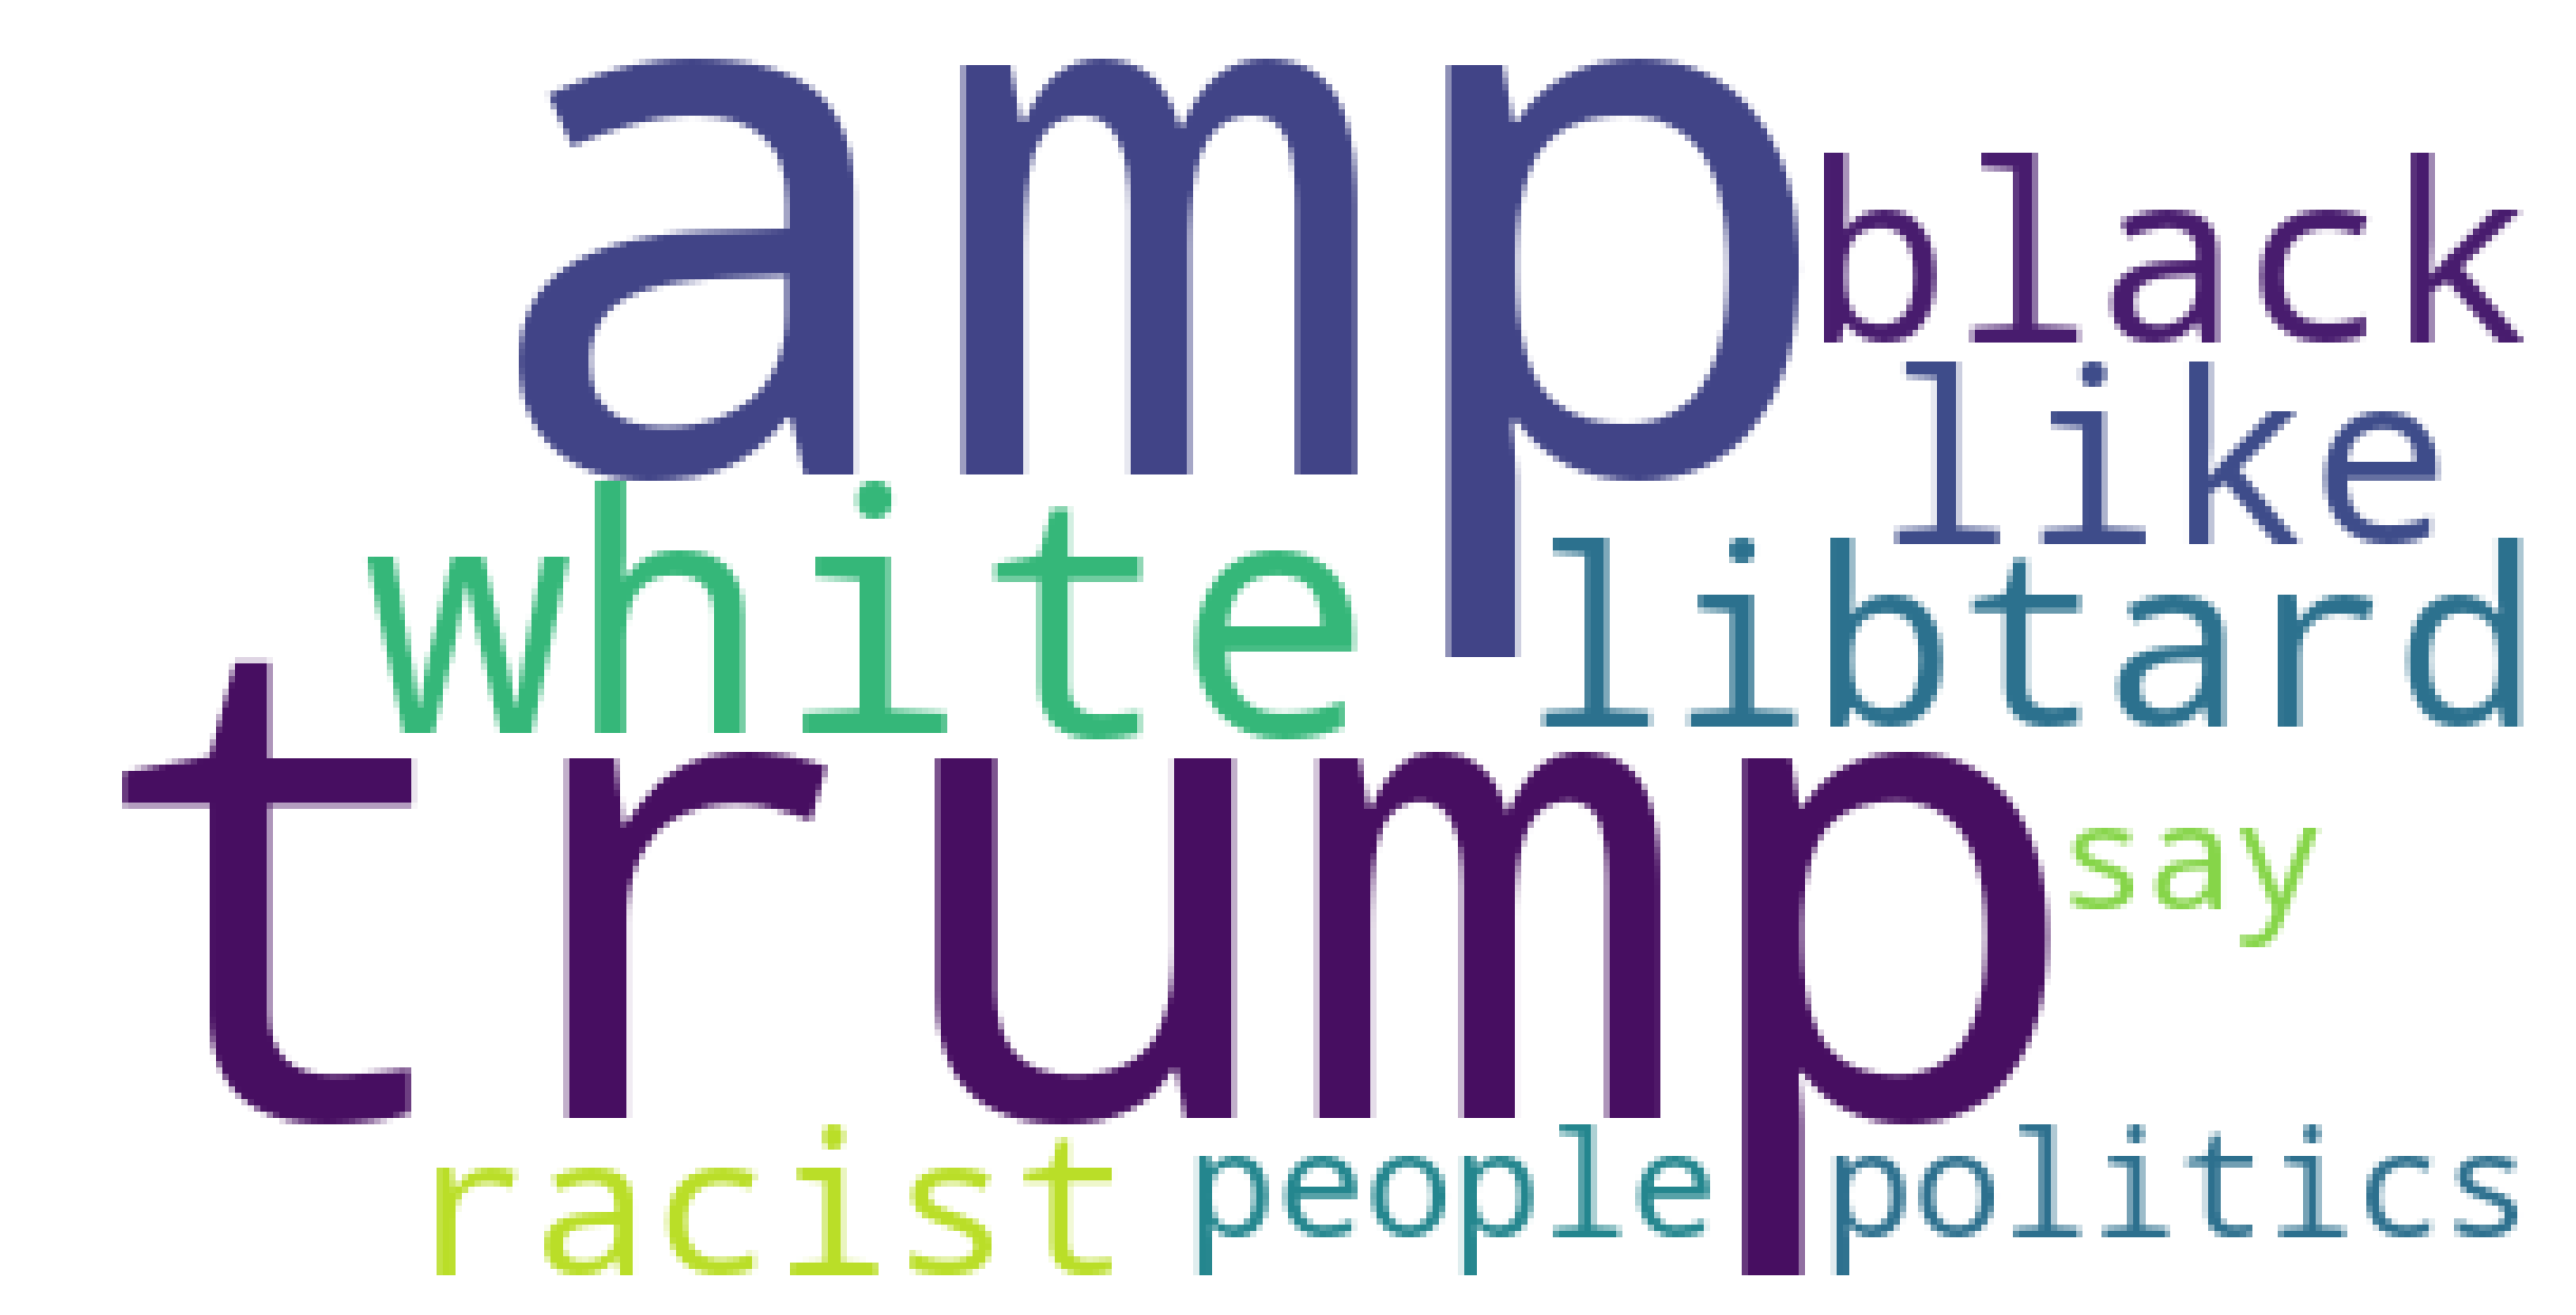

In [40]:
plt.figure(figsize=(12,8), dpi=300)
nuvem.generate_from_frequencies(dict(data_freq[:10].values))
plt.imshow(nuvem)
plt.axis('off')
plt.show()

### Retornar para formato de texto

In [41]:
train.head() # formato de lista

,id,label,tweet,palavras
0,1,0,"[father, dysfunctional, selfish, drag, kid, dy...",7
1,2,0,"[thank, lyft, credit, cant, use, cause, dont, ...",13
2,3,0,"[bihday, majesty]",2
3,4,0,"[model, love, u, take, u, time, ur]",7
4,5,0,"[factsguide, society, motivation]",3


In [42]:
train['tweet'] = train['tweet'].apply(lambda x: ' '.join(x))

In [43]:
test['tweet'] = test['tweet'].apply(lambda x: ' '.join(x))

###  Solucionar problema de desequilibrio dos dados

In [44]:
train['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

In [45]:
from sklearn.utils import resample

In [46]:
def equilibra_dados(train, pra_mais=True):
    train_minoria = train.loc[train['label']==1]
    train_maioria = train.loc[train['label']==0]
    if pra_mais: # equilibra pro maior valor
        menor_pro_maior = resample(train_minoria, 
                           replace=True, 
                           n_samples=len(train_maioria), 
                           random_state=123)
        train_equilibrado = pd.concat([menor_pro_maior, train_maioria])
    else: # equilibra pro menor valor
        maior_pro_menor = resample(train_maioria, 
                           replace=True, 
                           n_samples=len(train_minoria), 
                           random_state=123)
        train_equilibrado = pd.concat([maior_pro_menor, train_minoria])
    return train_equilibrado

In [47]:
train_equilibrado = equilibra_dados(train, pra_mais=True)

In [48]:
train_equilibrado

,id,label,tweet,palavras
19492,19493,1,might libtard libtard sjw liberal politics,6
16151,16152,1,good place sta learn abt one person amp bigot ...,10
25144,25145,1,allahsoil bernanke bail wall street dump 600 b...,10
30902,30903,1,wait somebody call dont see anybody,6
16522,16523,1,white people expats rest us immigrants socialc...,9
...,...,...,...,...
31956,31957,0,fish tomorrow carnt wait first time 2 years,8
31957,31958,0,eat isz youuu,3
31958,31959,0,see nina turner airwaves try wrap mantle genui...,14
31959,31960,0,listen sad songs monday morning otw work sad,8


In [49]:
len(train_equilibrado)

59440

In [50]:
train_equilibrado['label'].value_counts() # agora está equilibrado, o que melhora o desempenho do modelo em relação ao que estava antes

label
1    29720
0    29720
Name: count, dtype: int64

## Treinar Modelo

In [51]:
from sklearn.model_selection import train_test_split

In [52]:
X = train_equilibrado['tweet']
y = train_equilibrado['label']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [54]:
X_train.shape, y_train.shape

((41608,), (41608,))

In [55]:
X_test.shape, y_test.shape # 30% do total

((17832,), (17832,))

In [56]:
# definição do modelo
sgd = Pipeline([
    ('countVector', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('modelo', SGDClassifier())
])

In [57]:
sgd.fit(X_train, y_train) # modelo sendo treinado

Pipeline(steps=[('countVector', CountVectorizer()),
                ('tfidf', TfidfTransformer()), ('modelo', SGDClassifier())])

In [58]:
sgd_pred = sgd.predict(X_test) # gera a predição a partir do X_test

In [59]:
sgd_pred

array([0, 1, 1, ..., 1, 0, 1], dtype=int64)

## Avaliar Performance do Modelo

In [60]:
from sklearn.metrics import f1_score

In [61]:
sgd_score = f1_score(y_test, sgd_pred) # compara a predição do modelo com o y_test, que é o correto

In [62]:
sgd_score

0.96697956929873

Esse score varia caso o equilíbrio dos dados seja para mais ou para menos.<br>
Com equilíbrio para menos, o score é 85%.<br>
Com equilíbrio para mais, o score é 96%, mas provavelmente é um overfit, ou superadequação aos dados.

In [63]:
y_pred = sgd.predict(test['tweet'])
y_pred

array([0, 1, 0, ..., 1, 0, 0], dtype=int64)

## Finalização

In [64]:
finalizacao = pd.DataFrame({'id': test['id'], 'label': y_pred})

In [65]:
finalizacao.head()

,id,label
0,31963,0
1,31964,1
2,31965,0
3,31966,0
4,31967,0


In [66]:
# finalizacao.to_csv('pred_twitter.csv', index=False)